In [ ]:
import numpy as np
import pandas as pd
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
df = pd.read_excel('train.xlsx')
df

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
0,0,20230428-6634-194809261,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-20 20:39:15,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1
1,1,20220711-6634-144460018,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,NaT,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1
2,2,20221204-16563-171020423,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,NaT,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4
3,3,20230918-7491-223512699,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,NaT,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Активный,Номер «Стандарт»,1,3
4,4,20230529-6634-200121971,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,NaT,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,26169,20230310-7492-177993190,1,18240.0,9120,Банк. карта: Банк Россия (банк. карта),2023-01-07 17:45:18,NaT,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2
26170,26170,20230625-16563-206126520,1,69600.0,23200,Банк. карта: Банк Россия (банк. карта),2023-06-20 17:54:17,NaT,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Активный,Номер «Студия»,3,4
26171,26171,20220624-7492-137587082,1,55600.0,13900,Банк. карта: Банк Россия (банк. карта),2022-05-08 19:24:05,NaT,2022-06-24 15:00:00,4,2022-06-28 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2
26172,26172,20220427-7491-125459150,1,6300.0,0,Гарантия банковской картой,2022-02-19 09:55:50,2022-04-16 23:14:35,2022-04-27 15:00:00,1,2022-04-28 12:00:00,booking.com,Отмена,Номер «Стандарт»,2,3


In [ ]:
'''Удаляем ненужные столбцы'''
del df["№ брони"]
del df["Unnamed: 0"]

In [ ]:
'''Заменяет дату отмены на отмену (0/1)'''
df['Дата отмены'] = df['Дата отмены'].fillna(0)
df['Отмена'] =  df['Дата отмены'].apply(lambda x: 0 if x==0 else 1)
del df['Дата отмены']

In [ ]:
'''Убираем единичные поля в статусе брони'''
df['Статус брони'] = df['Статус брони'].apply(lambda x: 'Активный' if x == 'Ожидается оплата' else ( 'Отмена' if x == 'Освоб. заранее' else x))

In [ ]:
'''Способы оплаты делим по типу платформы'''
#df['Способ оплаты'] = df['Способ оплаты'].apply(lambda x: 'ComfortBooking' if x == 'Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)' or x == 'Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта (SberPay): Эквайринг ComfortBooking (Банк. карта) (SberPay)' or x == 'Банк. карта (Yandex Pay): Эквайринг ComfortBooking (Банк. карта) (Yandex Pay)' else ('TravelLine Pro' if x == 'Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)' else 'other'))

In [ ]:
df1 = df.apply(lambda col: col.astype('category').cat.codes if col.dtype == 'object' or col.dtype == 'datetime64[ns]'  else col)

In [ ]:
df1

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена
0,1,25700.0,0,2,16638,494,3,485,26,2,25,2,1,1
1,1,24800.0,12400,2,7291,194,2,191,23,0,25,2,1,0
2,1,25800.0,12900,2,12253,340,2,337,23,0,27,2,4,0
3,1,10500.0,0,2,22189,643,1,628,9,0,25,1,3,0
4,1,28690.0,28690,0,17692,525,2,515,23,0,24,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,2,13310,442,2,433,23,0,25,2,2,0
26170,1,69600.0,23200,2,18791,556,3,545,23,0,27,3,4,0
26171,1,55600.0,13900,2,5762,177,4,176,23,0,25,2,2,0
26172,1,6300.0,0,2,1822,119,1,115,17,2,25,2,3,1


In [ ]:
import seaborn as sns

<Axes: >

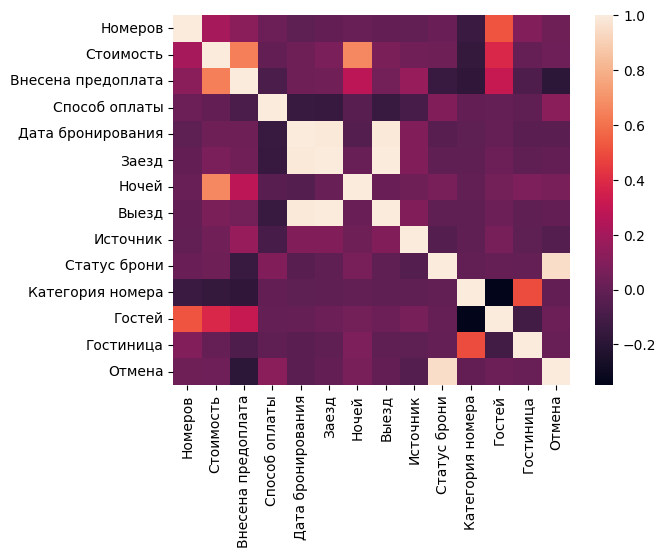

In [ ]:
sns.heatmap(df1.corr())

In [ ]:
df['Статус брони'].value_counts()

,count
Статус брони,
Активный,20982
Отмена,3405
Неподтвержденные,1787


In [ ]:
df['Статус брони']= df['Статус брони'].apply(lambda x: 'Активный' if x== 'Ожидается оплата' else ( 'Отмена' if x == 'Освоб. заранее' else x))
df

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена
0,1,25700.0,0,other,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1,1
1,1,24800.0,12400,other,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1,0
2,1,25800.0,12900,other,2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4,0
3,1,10500.0,0,other,2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Активный,Номер «Стандарт»,1,3,0
4,1,28690.0,28690,ComfortBooking,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,other,2023-01-07 17:45:18,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0
26170,1,69600.0,23200,other,2023-06-20 17:54:17,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Активный,Номер «Студия»,3,4,0
26171,1,55600.0,13900,other,2022-05-08 19:24:05,2022-06-24 15:00:00,4,2022-06-28 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0
26172,1,6300.0,0,other,2022-02-19 09:55:50,2022-04-27 15:00:00,1,2022-04-28 12:00:00,booking.com,Отмена,Номер «Стандарт»,2,3,1


In [ ]:
df['Статус брони'].value_counts()

,count
Статус брони,
Активный,20982
Отмена,3405
Неподтвержденные,1787


In [ ]:
df['Способ оплаты'].value_counts()

,count
Способ оплаты,
other,21785
ComfortBooking,2775
TravelLine Pro,1614


In [ ]:
#df['Способ оплаты'] = df['Способ оплаты'].apply(lambda x: 'ComfortBooking' if x == 'Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)' or x == 'Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта (SberPay): Эквайринг ComfortBooking (Банк. карта) (SberPay)' or x == 'Банк. карта (Yandex Pay): Эквайринг ComfortBooking (Банк. карта) (Yandex Pay)' else ('TravelLine Pro' if x == 'Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)' else 'other'))

In [ ]:
def extract_payment_system(payment_description):
  if 'SberPay' in payment_description:
        return 'SberPay'
  elif 'Yandex Pay' in payment_description:
        return 'Yandex Pay'
  elif 'МИР' in payment_description:
        return 'МИР'
  elif 'ComfortBooking' in payment_description:
        return 'ComfortBooking'
  elif 'Эквайринг' in payment_description:
        return 'Эквайринг'
  elif 'Система быстрых платежей' in payment_description:
        return 'Система быстрых платежей'
  elif 'Банк Россия' in payment_description:
        return 'Банк Россия'
  elif 'Внешняя система оплаты' in payment_description:
        return 'Внешняя система оплаты'
  else:
        return payment_description


In [ ]:
df['Способ оплаты'] = df['Способ оплаты'].apply(extract_payment_system)

In [ ]:
df['Способ оплаты'].value_counts()

,count
Способ оплаты,
other,21785
ComfortBooking,2775
TravelLine Pro,1614


In [ ]:
df['Источник'].value_counts()

,count
Источник,
Официальный сайт,21077
Бронирование из экстранета,1306
Яндекс.Путешествия,1132
ostrovok.ru,733
booking.com,629
Программа лояльности,618
booking.com (Booking.com),205
Bronevik.com(new),141
OneTwoTrip,141


In [ ]:
#df['Источник'] = df['Источник'].apply(lambda x:'Официальный сайт' if x == 'Официальный сайт' else 'неофициальный сайт' )

In [ ]:
df['Источник'].value_counts()

,count
Источник,
Официальный сайт,21077
Бронирование из экстранета,1306
Яндекс.Путешествия,1132
ostrovok.ru,733
booking.com,629
Программа лояльности,618
booking.com (Booking.com),205
Bronevik.com(new),141
OneTwoTrip,141


In [ ]:
df

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена
0,1,25700.0,0,other,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1,1
1,1,24800.0,12400,other,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1,0
2,1,25800.0,12900,other,2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4,0
3,1,10500.0,0,other,2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Активный,Номер «Стандарт»,1,3,0
4,1,28690.0,28690,ComfortBooking,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,other,2023-01-07 17:45:18,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0
26170,1,69600.0,23200,other,2023-06-20 17:54:17,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Активный,Номер «Студия»,3,4,0
26171,1,55600.0,13900,other,2022-05-08 19:24:05,2022-06-24 15:00:00,4,2022-06-28 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0
26172,1,6300.0,0,other,2022-02-19 09:55:50,2022-04-27 15:00:00,1,2022-04-28 12:00:00,booking.com,Отмена,Номер «Стандарт»,2,3,1


In [ ]:

'''Смотрим на даты'''
df.iloc[:,4:7]

,Дата бронирования,Заезд,Ночей
0,2023-04-20 20:37:30,2023-04-28 15:00:00,3
1,2022-06-18 14:17:02,2022-07-11 15:00:00,2
2,2022-11-14 22:59:30,2022-12-04 15:00:00,2
3,2023-09-08 15:55:53,2023-09-18 15:00:00,1
4,2023-05-20 19:54:13,2023-05-29 15:00:00,2
...,...,...,...
26169,2023-01-07 17:45:18,2023-03-10 15:00:00,2
26170,2023-06-20 17:54:17,2023-06-25 15:00:00,3
26171,2022-05-08 19:24:05,2022-06-24 15:00:00,4
26172,2022-02-19 09:55:50,2022-04-27 15:00:00,1


In [ ]:
df['Месяц заезда'] = df['Заезд'].dt.month
df['Разница времени'] = (df['Заезд']-df['Дата бронирования']).dt.total_seconds()
''' ВЫделяем месяц бронирования, и время брони до заезда'''
df

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена,Месяц заезда,Разница времени
0,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1,1,4,670950.0
1,1,24800.0,12400,Банк Россия,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1,0,7,1989778.0
2,1,25800.0,12900,Банк Россия,2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4,0,12,1699230.0
3,1,10500.0,0,Внешняя система оплаты,2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Активный,Номер «Стандарт»,1,3,0,9,860647.0
4,1,28690.0,28690,ComfortBooking,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,Банк Россия,2023-01-07 17:45:18,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,3,5346882.0
26170,1,69600.0,23200,Банк Россия,2023-06-20 17:54:17,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Активный,Номер «Студия»,3,4,0,6,421543.0
26171,1,55600.0,13900,Банк Россия,2022-05-08 19:24:05,2022-06-24 15:00:00,4,2022-06-28 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,6,4044955.0
26172,1,6300.0,0,Гарантия банковской картой,2022-02-19 09:55:50,2022-04-27 15:00:00,1,2022-04-28 12:00:00,booking.com,Отмена,Номер «Стандарт»,2,3,1,4,5807050.0


In [ ]:
del df['Заезд']
del df['Дата бронирования']
del df['Выезд']
'''Удаляем ненужные столбцы'''

'Удаляем ненужные столбцы'

In [ ]:
df

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена,Месяц заезда,Разница времени
0,1,25700.0,0,other,3,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1,1,4,670950.0
1,1,24800.0,12400,other,2,Официальный сайт,Активный,Номер «Стандарт»,2,1,0,7,1989778.0
2,1,25800.0,12900,other,2,Официальный сайт,Активный,Номер «Студия»,2,4,0,12,1699230.0
3,1,10500.0,0,other,1,Bronevik.com(new),Активный,Номер «Стандарт»,1,3,0,9,860647.0
4,1,28690.0,28690,ComfortBooking,2,Официальный сайт,Активный,Номер «Люкс»,4,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,other,2,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,3,5346882.0
26170,1,69600.0,23200,other,3,Официальный сайт,Активный,Номер «Студия»,3,4,0,6,421543.0
26171,1,55600.0,13900,other,4,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,6,4044955.0
26172,1,6300.0,0,other,1,booking.com,Отмена,Номер «Стандарт»,2,3,1,4,5807050.0


In [ ]:
''' Средняя стоимость каждой гостиницы'''
df.groupby('Гостиница')['Стоимость'].mean()


,Стоимость
Гостиница,
1,40208.727042
2,29388.526873
3,28296.256558
4,58065.008632


In [ ]:
del df['Гостей']
del df['Номеров']
''' Удаляем количество гостей, поскольку почти пряямая зависимость к категории номера'''

' Удаляем количество гостей, поскольку почти пряямая зависимость к категории номера'

In [ ]:
df["Категория номера"] = df["Категория номера"].astype("category")

In [ ]:
df["Категория номера"] = df["Категория номера"].cat.codes

In [ ]:
df

,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Статус брони,Категория номера,Гостиница,Отмена,Месяц заезда,Разница времени
0,25700.0,0,Внешняя система оплаты,3,Яндекс.Путешествия,Отмена,25,1,1,4,670950.0
1,24800.0,12400,Банк Россия,2,Официальный сайт,Активный,25,1,0,7,1989778.0
2,25800.0,12900,Банк Россия,2,Официальный сайт,Активный,27,4,0,12,1699230.0
3,10500.0,0,Внешняя система оплаты,1,Bronevik.com(new),Активный,25,3,0,9,860647.0
4,28690.0,28690,ComfortBooking,2,Официальный сайт,Активный,24,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...,...
26169,18240.0,9120,Банк Россия,2,Официальный сайт,Активный,25,2,0,3,5346882.0
26170,69600.0,23200,Банк Россия,3,Официальный сайт,Активный,27,4,0,6,421543.0
26171,55600.0,13900,Банк Россия,4,Официальный сайт,Активный,25,2,0,6,4044955.0
26172,6300.0,0,Гарантия банковской картой,1,booking.com,Отмена,25,3,1,4,5807050.0


In [ ]:
df = df.drop(columns = ["Статус брони"])
'''ohe = OneHotEncoder(sparse=True,drop='first')
data_encoding = pd.concat([df.select_dtypes('object'),df["Гостиница"],df["Месяц заезда"]], axis = 1)
data_numbers = df.select_dtypes(exclude = 'object')
data_numbers = data_numbers.drop(columns = ["Гостиница","Месяц заезда"])
ohe.fit(data_encoding)
features = ohe.get_feature_names_out()
codes = ohe.transform(data_encoding).toarray()
data_coded = pd.concat([data_numbers,pd.DataFrame(codes,columns = features).astype('int16')],axis = 1)
data_coded["Разница"] = data_coded["Внесена предоплата"] / data_coded["Стоимость"]'''

'ohe = OneHotEncoder(sparse=True,drop=\'first\')\ndata_encoding = pd.concat([df.select_dtypes(\'object\'),df["Гостиница"],df["Месяц заезда"]], axis = 1)\ndata_numbers = df.select_dtypes(exclude = \'object\')\ndata_numbers = data_numbers.drop(columns = ["Гостиница","Месяц заезда"])\nohe.fit(data_encoding)\nfeatures = ohe.get_feature_names_out()\ncodes = ohe.transform(data_encoding).toarray()\ndata_coded = pd.concat([data_numbers,pd.DataFrame(codes,columns = features).astype(\'int16\')],axis = 1)\ndata_coded["Разница"] = data_coded["Внесена предоплата"] / data_coded["Стоимость"]'

In [ ]:
df = df.apply(lambda col: col.astype('category').cat.codes if col.dtype == 'object' else col)

In [ ]:
'''data_coded'''
df

,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Категория номера,Гостиница,Отмена,Месяц заезда,Разница времени
0,25700.0,0,4,3,26,25,1,1,4,670950.0
1,24800.0,12400,3,2,23,25,1,0,7,1989778.0
2,25800.0,12900,3,2,23,27,4,0,12,1699230.0
3,10500.0,0,4,1,9,25,3,0,9,860647.0
4,28690.0,28690,0,2,23,24,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...
26169,18240.0,9120,3,2,23,25,2,0,3,5346882.0
26170,69600.0,23200,3,3,23,27,4,0,6,421543.0
26171,55600.0,13900,3,4,23,25,2,0,6,4044955.0
26172,6300.0,0,5,1,17,25,3,1,4,5807050.0


In [ ]:
df['Месяц заезда'] = pd.to_datetime(df['Месяц заезда']).astype(np.int64)

In [ ]:
df['Разница времени'] = pd.to_datetime(df['Разница времени']).astype(np.int64)

# Models

Скейлинг

Логистическая регрессия

In [ ]:
X = df.drop(columns = ["Отмена"])

y = df["Отмена"]

X

,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Категория номера,Гостиница,Месяц заезда,Разница времени
0,25700.0,0,4,3,26,25,1,4,670950.0
1,24800.0,12400,3,2,23,25,1,7,1989778.0
2,25800.0,12900,3,2,23,27,4,12,1699230.0
3,10500.0,0,4,1,9,25,3,9,860647.0
4,28690.0,28690,0,2,23,24,1,5,759947.0
...,...,...,...,...,...,...,...,...,...
26169,18240.0,9120,3,2,23,25,2,3,5346882.0
26170,69600.0,23200,3,3,23,27,4,6,421543.0
26171,55600.0,13900,3,4,23,25,2,6,4044955.0
26172,6300.0,0,5,1,17,25,3,4,5807050.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 42)
X_trainl, X_val, y_trainl, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state = 42)

In [ ]:
def c_best_selection(C_set, clf, X_t, y_t, X_val, y_val):
    auc_p_r = 0
    C = 1.0
    for C_i in C_set:
        clf.C = C_i
        clf.fit(X_t,y_t)
        a_x = clf.predict(X_val)

        precision, recall, th = precision_recall_curve(y_val, a_x)
        auc_precision_recall = auc(recall,precision)
        if auc_precision_recall > auc_p_r:
            auc_p_r = auc_precision_recall
            C = C_i
    print("C: ",C)
    return C

In [ ]:
best_c_LR = c_best_selection(np.arange(0.001,20,1), LogisticRegression(),X_trainl,y_trainl,X_val,y_val)

C:  0.001


In [ ]:
clf = LogisticRegression(penalty = "l2")
clf.C = best_c_LR
X_train = X
y_train = y
clf.fit(X_train,y_train)
print(X.columns.to_list())
print(clf.coef_.tolist())
coef = clf.coef_

table = pd.DataFrame({"Feature_name":X.columns.to_list(),"coefs": (clf.coef_*100000).tolist()[0]})
table = table.sort_values(by='coefs', ascending=False,key = lambda x:abs(x))
'''a_x = clf.predict(X_test)'''
table


['Стоимость', 'Внесена предоплата', 'Способ оплаты', 'Ночей', 'Источник', 'Категория номера', 'Гостиница', 'Месяц заезда', 'Разница времени']
[[6.08010869869104e-06, -0.00011404606442035096, -1.653568293342969e-08, -4.7687669480276736e-09, -1.2379450256116864e-07, -1.380942881978803e-07, -1.1436860731649438e-08, -3.591879058891606e-08, 5.712916589456313e-08]]


,Feature_name,coefs
1,Внесена предоплата,-11.404606
0,Стоимость,0.608011
5,Категория номера,-0.013809
4,Источник,-0.012379
8,Разница времени,0.005713
7,Месяц заезда,-0.003592
2,Способ оплаты,-0.001654
6,Гостиница,-0.001144
3,Ночей,-0.000477


In [ ]:
precision, recall, th = precision_recall_curve(y_test,a_x)
auc_precision_recall = auc(recall,precision)

fpr,tpr,th_roc = roc_curve(y_test,a_x)
auc_roc = auc(fpr,tpr)


In [ ]:
print(auc_roc)

0.7615099185213873


In [ ]:
print(clf.predict_proba(X))

[[0.45150665 0.54849335]
 [0.75945891 0.24054109]
 [0.77158051 0.22841949]
 ...
 [0.73421382 0.26578618]
 [0.4085286  0.5914714 ]
 [0.93356094 0.06643906]]


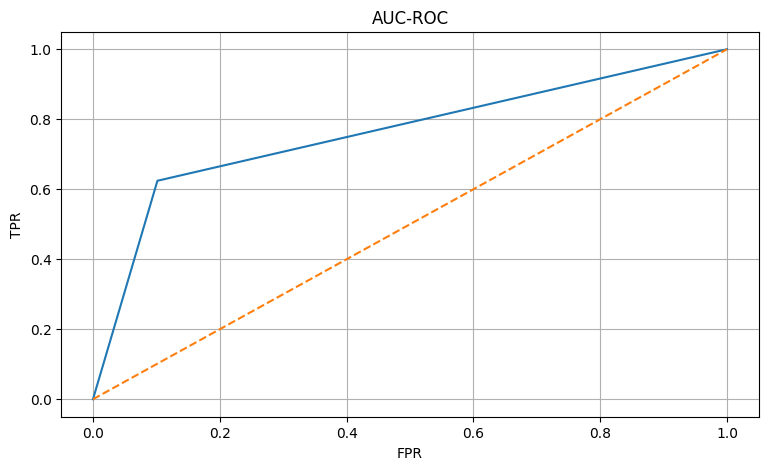

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(fpr,tpr,label = 'ROC')
plt.plot([0,1],[0,1],linestyle = '--')

plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
#best_c_linearSVC = c_best_selection(np.arange(0.001,100,1),LinearSVC(),X_trainl,y_trainl,X_val,y_val)

C:  20.000999999999998


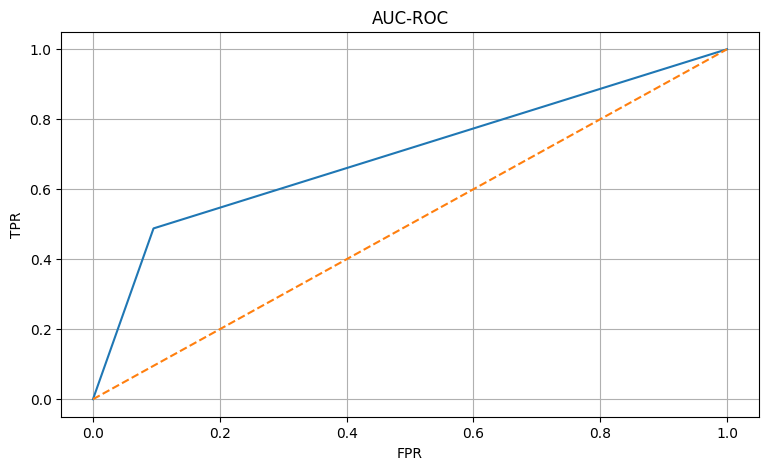

In [ ]:
'''clf = LinearSVC()
clf.C = best_c_linearSVC
clf.fit(X_train,y_train)
a_x = clf.predict(X_test)
precision, recall, th = precision_recall_curve(y_test,a_x)
auc_precision_recall = auc(recall,precision)

fpr,tpr,th_roc = roc_curve(y_test,a_x)
auc_roc = auc(fpr,tpr)
plt.figure(figsize=(9,5))
plt.plot(fpr,tpr,label = 'ROC')
plt.plot([0,1],[0,1],linestyle = '--')

plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()'''

## xgboost

In [ ]:
!pip install XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
clf = xgb.XGBClassifier(objective='multi:softprob',
    num_class=2,
    max_depth=7,
    learning_rate=0.5,
    n_estimators=500,
    subsample = 0.8,             # Доля выборки данных
    colsample_bytree =0.8,      # Доля признаков на дереве
    gamma = 0,                   # Регуляризация разделений
    alpha = 1 )                   # L1-регуляризация)
clf.fit(X_train, y_train)


XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=2, ...)

# Test

In [ ]:
dft = pd.read_excel('test.xlsx')
dft

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,0,20231129-16563-238946689,1,23750.0,23750,Банк. карта: Банк Россия (банк. карта),2023-11-28 10:34:43,2023-11-29 15:00:00,2,2023-12-01 12:00:00,Официальный сайт,Номер «Студия»,3,4
1,1,20221219-7491-174959103,1,15010.0,7505,Банк. карта: Банк Россия (банк. карта),2022-12-12 18:30:43,2022-12-19 15:00:00,2,2022-12-21 12:00:00,Официальный сайт,Номер «Стандарт»,2,3
2,2,20221211-6634-172724329,1,8400.0,8400,Отложенная электронная оплата: Банк Россия (ба...,2022-11-25 22:03:59,2022-12-11 15:00:00,1,2022-12-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
3,3,20230821-6634-212247350,1,42500.0,42500,Банк. карта: Банк Россия (банк. карта),2023-07-18 15:45:46,2023-08-21 15:00:00,3,2023-08-24 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1
4,4,20230326-6634-189784563,1,62500.0,11900,Система быстрых платежей: Эквайринг ComfortBoo...,2023-03-23 11:04:13,2023-03-26 15:00:00,5,2023-03-31 12:00:00,Официальный сайт,Номер «Стандарт»,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11213,11213,20220507-7492-130458541,1,50200.0,50200,Банк. карта [Кешбэк. МИР]: Эквайринг TravelLin...,2022-03-27 21:30:38,2022-05-07 15:00:00,2,2022-05-09 12:00:00,Официальный сайт,Номер «Студия»,4,2
11214,11214,20240217-6634-235901857,1,190100.0,43500,Система быстрых платежей: Эквайринг ComfortBoo...,2023-11-11 17:51:55,2024-02-16 15:00:00,5,2024-02-21 12:00:00,Официальный сайт,Коттедж с 2 спальнями,4,1
11215,11215,20220209-6634-124107676,1,42300.0,42300,Банк. карта: Банк Россия (банк. карта),2022-02-09 02:23:14,2022-02-09 15:00:00,1,2022-02-10 12:00:00,Официальный сайт,Коттедж с 3 спальнями,5,1
11216,11216,20230128-6634-179977236,1,27900.0,27900,Банк. карта: Банк Россия (банк. карта),2023-01-21 09:10:17,2023-01-28 15:00:00,1,2023-01-29 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1


In [ ]:
del dft["№ брони"]
del dft["Unnamed: 0"]

In [ ]:
'''Способы оплаты делим по типу платформы'''
dft['Способ оплаты'] = dft['Способ оплаты'].apply(lambda x: 'ComfortBooking' if x == 'Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)' or x == 'Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта (SberPay): Эквайринг ComfortBooking (Банк. карта) (SberPay)' or x == 'Банк. карта (Yandex Pay): Эквайринг ComfortBooking (Банк. карта) (Yandex Pay)' else ('TravelLine Pro' if x == 'Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)' else 'other'))

In [ ]:
dft['Способ оплаты'] = dft['Способ оплаты'].apply(extract_payment_system)


In [ ]:
#dft['Способ оплаты'] = dft['Способ оплаты'].apply(lambda x: 'ComfortBooking' if x == 'Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)' or x == 'Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта (SberPay): Эквайринг ComfortBooking (Банк. карта) (SberPay)' or x == 'Банк. карта (Yandex Pay): Эквайринг ComfortBooking (Банк. карта) (Yandex Pay)' else ('TravelLine Pro' if x == 'Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)' else 'other'))

In [ ]:
dft['Источник'] = dft['Источник'].apply(lambda x:'Официальный сайт' if x == 'Официальный сайт' else 'неофициальный сайт' )

In [ ]:
dft['Месяц заезда'] = dft['Заезд'].dt.month
dft['Разница времени'] = (dft['Заезд']-dft['Дата бронирования']).dt.total_seconds()

In [ ]:
del dft['Заезд']
del dft['Дата бронирования']
del dft['Выезд']
del dft['Гостей']
del dft['Номеров']

In [ ]:
dft["Категория номера"] = dft["Категория номера"].astype("category")
dft["Категория номера"] = dft["Категория номера"].cat.codes

In [ ]:
'''ohe = OneHotEncoder(sparse=True,drop='first')
data_encoding = pd.concat([dft.select_dtypes('object'),dft["Гостиница"],dft["Месяц заезда"]], axis = 1)
data_numbers = dft.select_dtypes(exclude = 'object')
data_numbers = data_numbers.drop(columns = ["Гостиница","Месяц заезда"])
ohe.fit(data_encoding)
features = ohe.get_feature_names_out()
codes = ohe.transform(data_encoding).toarray()
data_coded = pd.concat([data_numbers,pd.DataFrame(codes,columns = features).astype('int16')],axis = 1)
data_coded["Разница"] = data_coded["Внесена предоплата"] / data_coded["Стоимость"]'''

In [ ]:
dft = dft.apply(lambda col: col.astype('category').cat.codes if col.dtype == 'object' else col)

In [ ]:
dft

,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Категория номера,Гостиница,Месяц заезда,Разница времени
0,23750.0,23750,3,2,20,25,4,11,102317.0
1,15010.0,7505,3,2,20,23,3,12,592157.0
2,8400.0,8400,3,1,20,23,1,12,1356961.0
3,42500.0,42500,3,3,20,19,1,8,2934854.0
4,62500.0,11900,0,5,20,23,1,3,273347.0
...,...,...,...,...,...,...,...,...,...
11213,50200.0,50200,6,2,20,25,2,5,3518962.0
11214,190100.0,43500,0,5,20,20,1,2,8370485.0
11215,42300.0,42300,3,1,20,21,1,2,45406.0
11216,27900.0,27900,3,1,20,19,1,1,625783.0


In [ ]:
X

,Стоимость,Внесена предоплата,Ночей,Категория номера,Разница времени,Способ оплаты_TravelLine Pro,Способ оплаты_other,"Источник_Acase.ru (ООО ""АКАДЕМ-ОНЛАЙН"")","Источник_Acase.ru (ООО ""КАЛЕЙДОСКОП"")","Источник_Acase.ru (ООО ""ПРАНДИУМ"")",...,Месяц заезда_4,Месяц заезда_5,Месяц заезда_6,Месяц заезда_7,Месяц заезда_8,Месяц заезда_9,Месяц заезда_10,Месяц заезда_11,Месяц заезда_12,Разница
0,25700.0,0,3,25,670950.0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0.000000
1,24800.0,12400,2,25,1989778.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0.500000
2,25800.0,12900,2,27,1699230.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.500000
3,10500.0,0,1,25,860647.0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.000000
4,28690.0,28690,2,24,759947.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,18240.0,9120,2,25,5346882.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.500000
26170,69600.0,23200,3,27,421543.0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0.333333
26171,55600.0,13900,4,25,4044955.0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0.250000
26172,6300.0,0,1,25,5807050.0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0.000000


In [ ]:
ans = clf.predict_proba(dft)
b_x = []
for i in ans:
  b_x.append(i[0])


pd.DataFrame(b_x).to_csv("attempt3.2.csv",index=False)


